In [4]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Set directories for clean and stego images
clean_dir = 'clean'  # Replace with your directory
stego_dir = 'stego'  # Replace with your directory

# Preprocess function to resize images to 128x128
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    image = cv2.resize(image, (128, 128))  # Resize to 128x128
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    return image

# Load and preprocess clean and stego images
clean_images = [os.path.join(clean_dir, fname) for fname in os.listdir(clean_dir)]
stego_images = [os.path.join(stego_dir, fname) for fname in os.listdir(stego_dir)]

X_clean = np.array([preprocess_image(img) for img in clean_images])
X_stego = np.array([preprocess_image(img) for img in stego_images])

# Create labels for clean and stego images
y_clean = np.zeros(len(X_clean))  # Label 0 for clean images
y_stego = np.ones(len(X_stego))   # Label 1 for stego images

# Combine data and labels
X = np.concatenate([X_clean, X_stego], axis=0)
y = np.concatenate([y_clean, y_stego], axis=0)

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compute class weights to handle imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

In [2]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(128, 128, 1),  # Grayscale input
    weights=None,              # No preloaded weights since we're using grayscale
    include_top=False          # Exclude the top classification layers
)

# Add custom classification head
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Binary classification

# Define the complete model
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,  # Adjust based on resources
    batch_size=32,  # Use a batch size that fits your memory constraints
    class_weight=class_weights,
    verbose=1
)




Epoch 1/5


400/400 [==============================] - 594s 1s/step - loss: 0.7067 - accuracy: 0.6097 - val_loss: 0.6971 - val_accuracy: 0.2397
Epoch 2/5
400/400 [==============================] - 452s 1s/step - loss: 0.6932 - accuracy: 0.7437 - val_loss: 0.7025 - val_accuracy: 0.2397
Epoch 3/5
400/400 [==============================] - 296s 731ms/step - loss: 0.6932 - accuracy: 0.3940 - val_loss: 0.7043 - val_accuracy: 0.2397
Epoch 4/5
400/400 [==============================] - 268s 669ms/step - loss: 0.6932 - accuracy: 0.4735 - val_loss: 0.7044 - val_accuracy: 0.2397
Epoch 5/5
400/400 [==============================] - 238s 596ms/step - loss: 0.6932 - accuracy: 0.3882 - val_loss: 0.7059 - val_accuracy: 0.2397


In [3]:
model.save('mobilenetv2_lsb_model.h5')


c:\Users\aadit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [4]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

100/100 [==============================] - 11s 111ms/step - loss: 0.7059 - accuracy: 0.2397
Test Accuracy: 0.24


In [8]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Clean', 'Steganographed']))




100/100 [==============================] - 16s 131ms/step

Classification Report:
                precision    recall  f1-score   support

         Clean       0.24      1.00      0.39       767
Steganographed       0.00      0.00      0.00      2433

      accuracy                           0.24      3200
     macro avg       0.12      0.50      0.19      3200
  weighted avg       0.06      0.24      0.09      3200



c:\Users\aadit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aadit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aadit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

100/100 [==============================] - 13s 125ms/step
Confusion Matrix:
[[ 767    0]
 [2433    0]]
Accuracy: 0.2397
ROC-AUC Score: 0.4900


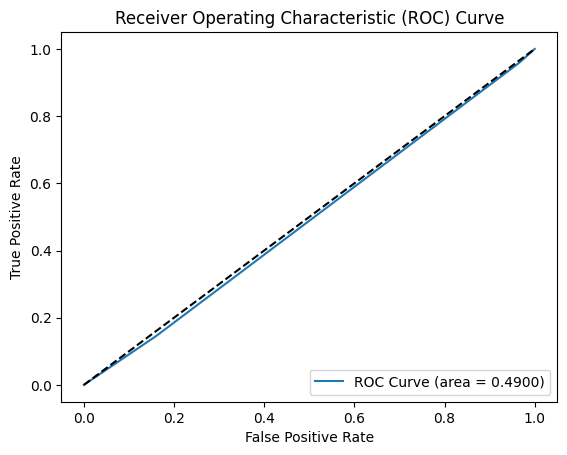

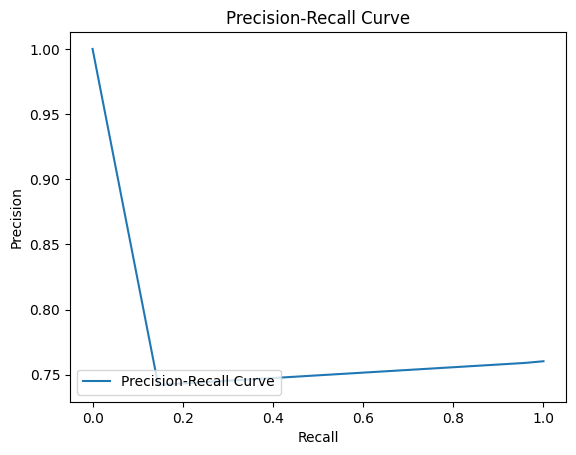

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# Predict probabilities and classes
y_pred_prob = model.predict(X_test)
y_pred_class = (y_pred_prob > 0.5).astype(int).flatten()  # Threshold at 0.5 for binary classification

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_class))

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred_class)
print(f"Accuracy: {accuracy:.4f}")

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [12]:
# Calculate evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_fscore_support

# Predict probabilities and classes
y_pred_prob = model.predict(X_test)
y_pred_class = (y_pred_prob > 0.5).astype(int).flatten()  # Binary classification threshold

# Compute metrics
conf_matrix = confusion_matrix(y_test, y_pred_class)
accuracy = accuracy_score(y_test, y_pred_class)
roc_auc = roc_auc_score(y_test, y_pred_prob)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_class, average='binary')

# Create evaluation matrix
evaluation_matrix = {
    "Confusion Matrix": conf_matrix.tolist(),  # Convert to list for easier readability
    "Accuracy": accuracy,
    "ROC-AUC": roc_auc,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1_score,
}

# Print evaluation matrix
print("Evaluation Matrix:")
for metric, value in evaluation_matrix.items():
    print(f"{metric}: {value}")


100/100 [==============================] - 12s 116ms/step
Evaluation Matrix:
Confusion Matrix: [[767, 0], [2433, 0]]
Accuracy: 0.2396875
ROC-AUC: 0.4899676385809847
Precision: 0.0
Recall: 0.0
F1-Score: 0.0


c:\Users\aadit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
